In [6]:
import os
os.system('pip install -U -r requirements.txt')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import pydotplus
from sklearn.tree import export_graphviz
import joblib


In [9]:
# Import data
file_name = "docs/19062019 clean 44 3.txt"
l,fam,a,mm,fm,ba,ls,mgr,fgr,l_r,o_r,tf=np.loadtxt(file_name, unpack="True") #unpack the data

In [11]:
df = pd.DataFrame(list(zip(mgr, a, mm, fm, tf, ba, ls)), columns=['mgr','a','mm','fm','tf','ba', 'ls'])

df.head()

,mgr,a,mm,fm,tf,ba,ls
0,6.0,60.0,2.0,5.0,7.0,1989.0,600.0
1,15.0,48.0,4.0,4.0,8.0,2003.0,1000.0
2,15.0,55.0,3.0,4.0,7.0,2011.0,700.0
3,7.0,52.0,4.0,1.0,5.0,1995.0,390.0
4,10.0,55.0,3.0,2.0,5.0,1996.0,450.0


Here,  
* **mgr**: Male guest room usage (days)  <br>
* **a**:   Age of house owner (years)  <br>
* **mm**:  # of male members in the house <br>
* **fm**:  # Number of female members in the house <br>
* **tf**:  # Total number of members in the house <br>
* **ba**:  building age (year of construction) <br>
* **ls**:  Land size (sq ft.) <br>

In [12]:
df.describe()

,mgr,a,mm,fm,tf,ba,ls
count,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000
mean,39.864055,52.973502,3.561060,3.283410,6.844470,2003.256912,749.987327
std,79.096571,12.308810,1.840767,1.670796,2.617483,10.925759,939.889718
min,0.000000,0.000000,0.000000,0.000000,0.000000,1969.000000,120.000000
25%,4.000000,45.000000,2.000000,2.000000,5.000000,1995.000000,400.000000
50%,10.000000,55.000000,3.000000,3.000000,7.000000,2006.000000,500.000000
75%,30.000000,60.000000,4.000000,4.000000,8.000000,2013.000000,750.000000
max,360.000000,89.000000,11.000000,11.000000,18.000000,2019.000000,10000.000000


The data does not have any missing or NaN values. All the features are numeric (although some are discrete) 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 7 columns):
mgr    868 non-null float64
a      868 non-null float64
mm     868 non-null float64
fm     868 non-null float64
tf     868 non-null float64
ba     868 non-null float64
ls     868 non-null float64
dtypes: float64(7)
memory usage: 47.5 KB


### Exploratory data analysis

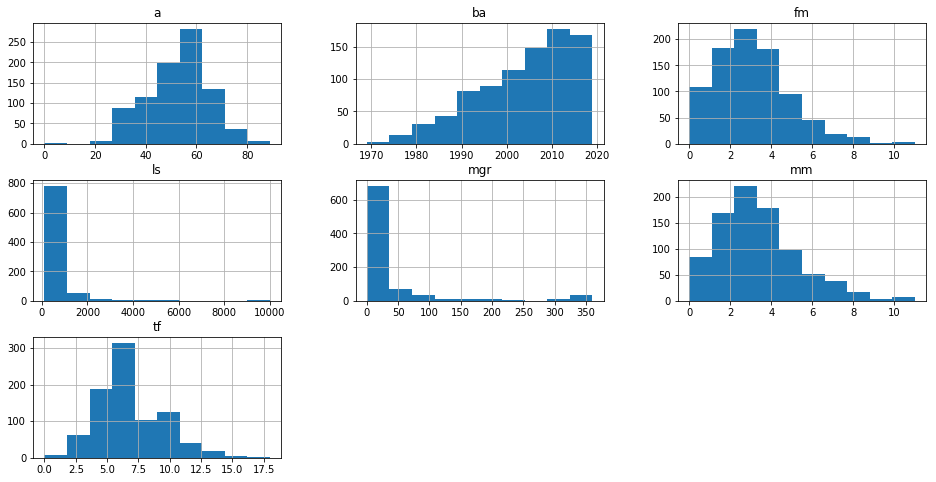

In [14]:
df.hist(figsize=(16,8))
plt.show()


Some variables like *mgr* (target variable in our case) are heavily skewed. Also the values are uncomparable by orders of magnitude. This may need some scaling and transformation later on.

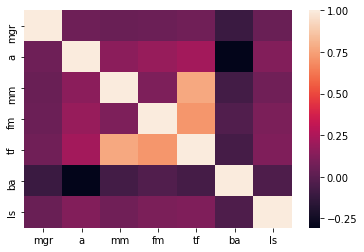

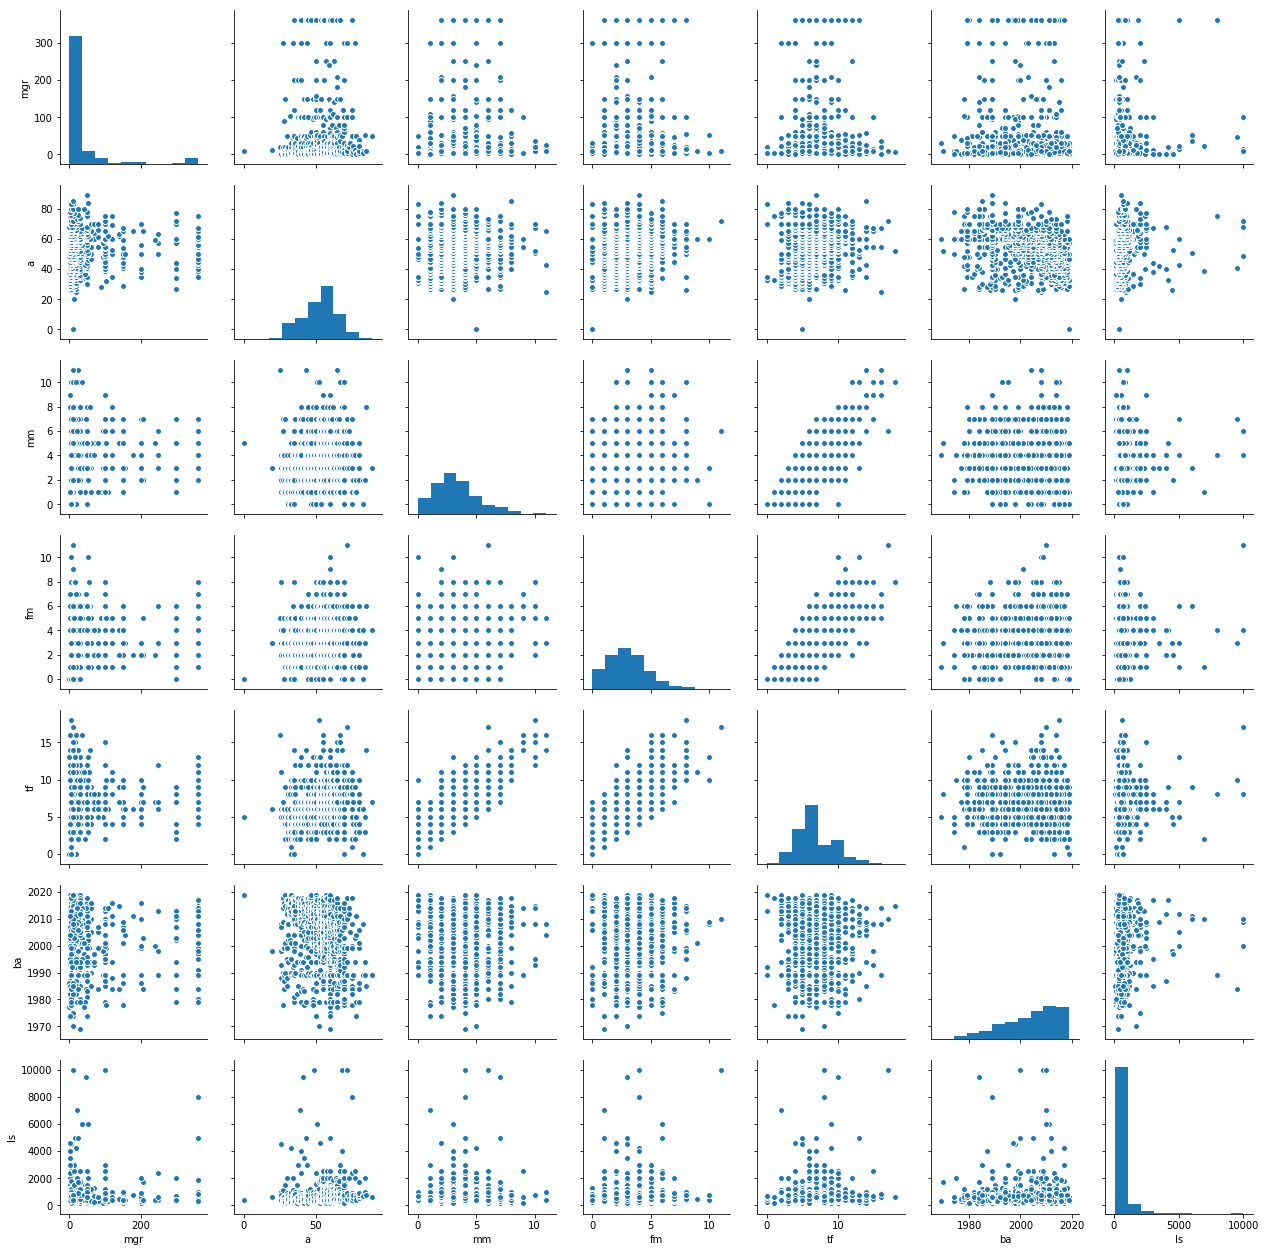

In [15]:
corr = df.corr()
sns.heatmap(corr)
plt.show()

sns.pairplot(df)

Building age (ba) doesn't really show any correlation with *target* or other *inputs*. This should be removed from the training set later. For now just create a *test set* and set it aside 

In [16]:
train_set_original, test_set_original = train_test_split(df, test_size=0.3, random_state=42)

Create cutom functions to include in the pipeline. I personally have come to love Pipelines

In [17]:
# Custom functions to include in the pipeline

class column_drop(BaseEstimator, TransformerMixin):
    def __init__(self, column_list=None):
        self.column_list = column_list
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.column_list == None:
            return X
        else:
            X_reduced = X.drop(self.column_list, axis=1)
            return X_reduced.values
    
class custom_transform(BaseEstimator, TransformerMixin):
    def __init__(self, column_list=None, func=lambda x:x*1):
        self.column_list=column_list
        self.func=func
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if column_list is not None:
            X_columns_calculated = self.func(X[:,self.column_list])
            X_reduced            = np.delete(X, self.column_list, axis=1)
            X_transformed        = np.c_[X_reduced, X_columns_calculated]
            
        else:
            X_columns_calculated = self.func(X)
            X_transformed        = X_columns_calculated
        return X_transformed

['mgr', 'a', 'mm', 'fm', 'tf', 'ba', 'ls']


,a,mm,fm,tf,mgr_sqrt,ls_sqrt
a,1.000000,0.122828,0.192050,0.206243,0.110083,0.221146
mm,0.122828,1.000000,0.140489,0.780425,0.080048,0.054073
fm,0.192050,0.140489,1.000000,0.728689,0.109508,0.087790
tf,0.206243,0.780425,0.728689,1.000000,0.124525,0.092844
mgr_sqrt,0.110083,0.080048,0.109508,0.124525,1.000000,0.051782
ls_sqrt,0.221146,0.054073,0.087790,0.092844,0.051782,1.000000


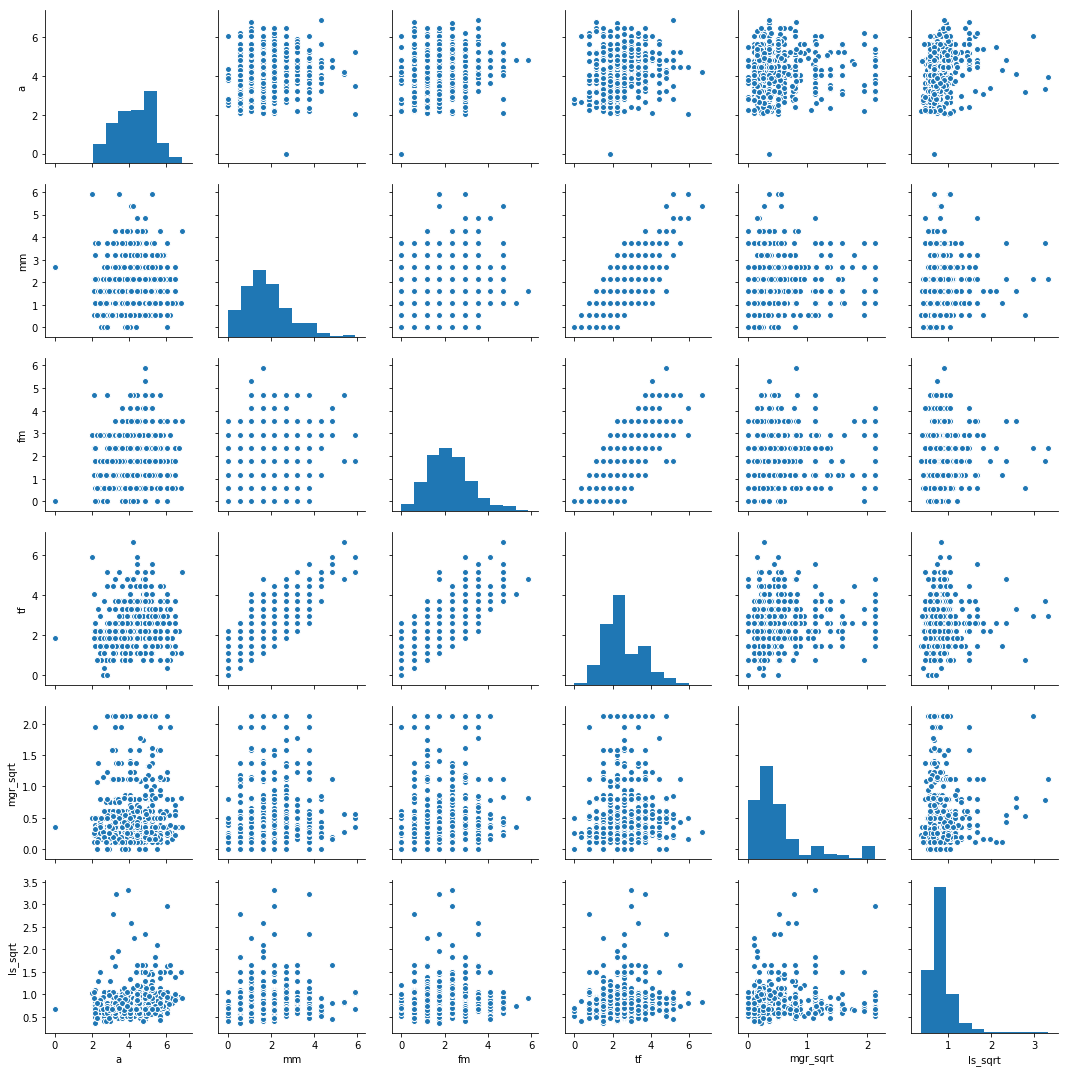

In [18]:
column_list = list(train_set_original.columns)
print(column_list) # ba is removed in the pipeline and mgr and ls are transformed(subsequently removed)

transformation_pipeline = Pipeline([('drop_column', column_drop(column_list=['ba'])), # Should be the first one 
                                    # as it can accept DataFrame and outputs numpy array
                                    ('scaling',StandardScaler(copy=True,with_mean=False)),
                                    ('custom_transform', custom_transform(column_list=[0,5], func=np.sqrt)),
    
]) 

train_set_transformed    = transformation_pipeline.fit_transform(train_set_original)

df_train_set_transformed = pd.DataFrame(train_set_transformed, columns=['a', 'mm', 'fm', 'tf'] + ['mgr_sqrt', 'ls_sqrt']) 
sns.pairplot(df_train_set_transformed)

df_train_set_transformed.corr()

Scaling the features to get similar scale and transforming tail heavy variables through the pipeline we can infer which variables are significant for output prediction. Although this decision to select influential features can also be made iterative.

Since *mgr_sqrt* bears relatively stronger correlation with only *a*, *fm* and *mm* it makes sense to only retain these features. Also since *fm* and *mm* are correlated with *tf* let's use only *fm* and *mm* as predictors

,a,mm,fm,mgr_sqrt
a,1.000000,0.122828,0.192050,0.110083
mm,0.122828,1.000000,0.140489,0.080048
fm,0.192050,0.140489,1.000000,0.109508
mgr_sqrt,0.110083,0.080048,0.109508,1.000000


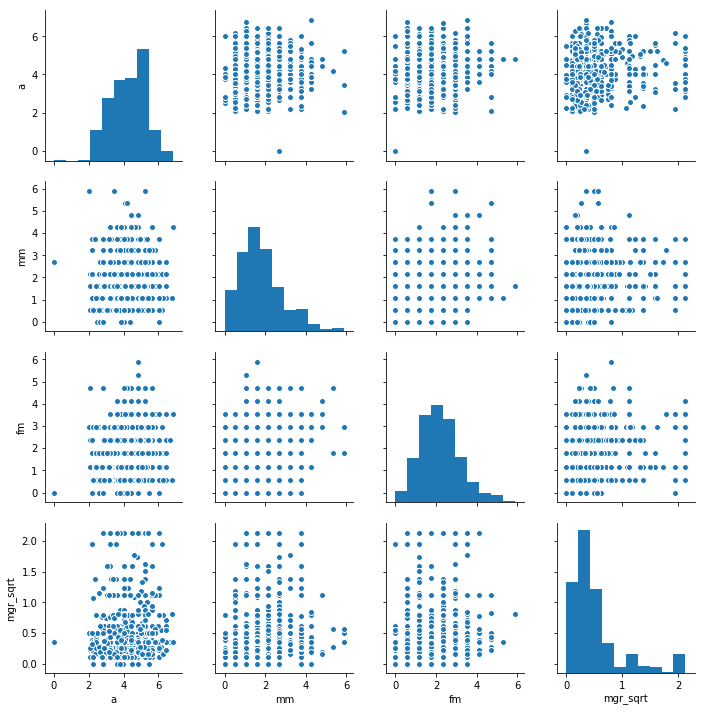

In [19]:
transformation_pipeline = Pipeline([('drop_column', column_drop(column_list=['tf','ba', 'ls'])), # Should be the first one 
                                    # as it can accept DataFrame and outputs numpy array
                                    ('scaling',StandardScaler(copy=True,with_mean=False)),
                                    ('custom_transform', custom_transform(column_list=[0], func=np.sqrt)),
    
]) 

train_set_transformed    = transformation_pipeline.fit_transform(train_set_original)

df_train_set_transformed = pd.DataFrame(train_set_transformed, columns=['a', 'mm', 'fm'] + ['mgr_sqrt']) 
sns.pairplot(df_train_set_transformed)

df_train_set_transformed.corr()

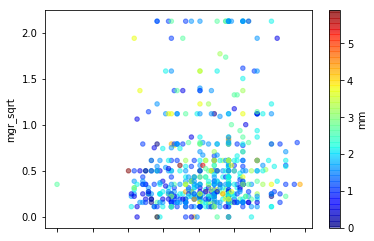

In [20]:
df_train_set_transformed.plot(kind='scatter', x='a', y='mgr_sqrt', alpha=0.5,
                               c='mm', cmap=plt.get_cmap('jet'), colorbar=True)

In [21]:
df_train_set_transformed_features = df_train_set_transformed.drop('mgr_sqrt',axis=1)
df_train_set_transformed_label    = df_train_set_transformed['mgr_sqrt'].copy()

tree_reg = DecisionTreeRegressor(max_depth=12, min_weight_fraction_leaf=0.002, random_state=4)

scores_tree = cross_val_score(tree_reg, df_train_set_transformed_features, df_train_set_transformed_features, 
                         scoring='neg_mean_squared_error', cv=30)

print(-scores_tree, '\n', -scores_tree.mean(), scores_tree.std(), '\n')

tree_reg.fit(df_train_set_transformed_features, df_train_set_transformed_label)

dot_data = export_graphviz(
            tree_reg,
            out_file=None,
            feature_names=df_train_set_transformed_features.columns,
            class_names=['mgr_sqrt'],
            rounded=True,
            filled=True
        )

graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('docs/visualise_decision_tree.png')


tree_predictions_training_set = tree_reg.predict(df_train_set_transformed_features)
print("Goodness of fit on training Set", round(r2_score(tree_predictions_training_set, df_train_set_transformed_label),2)*100, '%')



[0.16073217 0.08406146 0.07043541 0.03367365 0.10767642 0.04462325
 0.11588775 0.05341723 0.03763356 0.14838305 0.05866567 0.09174791
 0.04324007 0.06575231 0.0769423  0.09805632 0.04122443 0.08084159
 0.13998634 0.05154801 0.05242625 0.07958337 0.02499516 0.09614258
 0.05654417 0.04072968 0.04960807 0.2127201  0.07370986 0.04784851] 
 0.07796122189369255 0.042140954695422596 

Goodness of fit on training Set 7.000000000000001 %


In [22]:
# Save the model to re-use later

joblib.dump(tree_reg, 'docs/tree_reg.joblib')


['docs/tree_reg.joblib']

In [23]:
# and later re-use it
import joblib

tree_reg = joblib.load('docs/tree_reg.joblib')


There is clearly no discernable pattern that can be inferred from the plots and using Decision tree, the model either tends to severly underfit or severly overfit the data just on small change of hyper-parameters.

There doesn't seem to be any relationship so far and at this point even Test set evaluation is meaningless. The exercise is stopped for now.

### Using Test Set

In [221]:
# test_set_transformed    = transformation_pipeline.transform(test_set_original)

# df_test_set_transformed = pd.DataFrame(test_set_transformed, columns=['a', 'mm', 'fm'] + ['mgr_sqrt'])

# df_test_set_transformed_features = df_test_set_transformed.drop('mgr_sqrt',axis=1)
# df_test_set_transformed_label    = df_test_set_transformed['mgr_sqrt'].copy()

# test_predict = tree_reg.predict(df_test_set_transformed_features)
# print(mean_squared_error(test_predict, df_test_set_transformed_label))

# print("Goodness of fit on test Set", round(r2_score(test_predict, df_test_set_transformed_label),2)*100, '%')